## Simulation of Digital Signal Processing Algorithms



The following note book is provided to simulat audio signal for the purpose of vidulaising the perfomance of 
signal processing algorithms, and techniques for time difference of arrival method.




### Author: Kananelo Chabeli

### ------------------------------Imports-------------------------

In [1]:
#Imports 
import sounddevice as sd
from scipy import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Implementation of functions that read and record the wave audio files*****************

In [2]:
#define a function that reads a wave file from the given file name and returns raw wave file data and sample rate
def read_wav(filename,play=False):
    rate,data=io.wavfile.read(filename)
    if play:
        sd.play(data,rate)
    return data,rate
def record_wav(filename,duration,sampling_rate,channels=1):
    recording=sd.rec(int(duration*sampling_rate),samplerate=sampling_rate,channels=channels) #record sound
    sd.wait() #wait for the recording to complete
    io.wavfile.write(filename,sampling_rate,recording)
    return recording

### Implementation of functions that plot signals in desired domains

In [3]:
#Function that computes time axis samples for time-domain plotting
def time_axis(samples,step):
    return np.linspace(0,(samples-1)*step,int(samples))
#function that generates frequency axis samples for frequency domain plot

def freq_axis(samples,time_step):
    freq_step=1/(samples*time_step) #samples spacing in frequency domain
    if samples % 2 == 0:
       return  np.arange((-samples/2)*freq_step,((samples/2))*freq_step,freq_step)
    return np.arange((-(samples+1)/2)*freq_step,((samples-1)/2)*freq_step,freq_step)
#coming
def time_plot(t,xv,title="Time domain plot of the signal",ylab="magnitudes",label="signal1"):
    if len(t)!=len(xv):
        print("Given arrays must have same dimesions!")
        return
    plt.plot(t,xv,label=label)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlabel("time(s)")
    plt.show()
#coming
def spectral_plot(f,xv,time_step,title="Spectral plot of the signal",ylab="magnitude",plot=True):
    if len(f) !=len(xv):
        print("Given arrays must have same dimesions!")
        return None
    XV=np.fft.fft(xv)
    XV_Abs=time_step*np.fft.fftshift(np.abs(XV))
    if plot:
        plt.plot(f,XV_Abs)
        plt.title(title)
        plt.xlabel("Frequency(Hz)")
        plt.ylabel(ylab)
        plt.show()
    return XV
#comming
def spectrogral_plot(data,rate,title="Spectrogram of the Signal"):
    f,t,Sxx=signal.spectrogram(data,rate) #Compute the spectrum
    plt.pcolormesh(t, f, Sxx) #plot the spectrum
    plt.title(title)
    plt.ylabel("$Frequency(Hz)$")
    plt.xlabel("$Time(s)$")
    plt.show()
    

### Implementation of Finite Impulse Respose Low Pass Filter for Audio Signal Processing

In [4]:
#the following fucntion applies Finite Impulse Respose Filter on the signal passed and returns the filtered signal
def finite_impulse_response_filter(target_signal,cut_off,sampling_rate,length=29,width=10,response=False):
    """
        This function designs and applies a low pass Finite Impulse Respose filter
        on the target_singnal for the given sampling rate, cut_off frequency and transition region width. 
        The function plots the filter respose if the parameter 'response' is set to true, and returns the filtered signal 
    """
    #-----------------Define the Nyquist Frequency-------------
    Nyquist_rate=sampling_rate/2
    #----------------Define Normalized cut-off frequency-------
    normalized_cutoff=cut_off/Nyquist_rate
    #---------------Obtain the filter coeficients--------------
    filter_coeff=signal.firwin(length,normalized_cutoff,width=width)
    if response:
        [w,h]=signal.freqz(filter_coeff,worN=20_000)
        w=sampling_rate*w/(2*np.pi)
        h_db=20*np.log10(abs(h))
        plt.plot(w,h_db)
        plt.title("Frequency Response of the Finite Impulse Response Low Pass")
        plt.ylabel("Magnitude(dB)")
        plt.xlabel("Frequency(Hz)")
        plt.show()
    filtered_signal=signal.lfilter(filter_coeff,1.0,target_signal)
    return filtered_signal
    

## Implement Functions that perform Generalized Cross Correlation 

### 1: Generalized Cross Correlation Phase Transform : GCC-PHAT

In [5]:
# Function that takes in two signals, and perform GCC-PHAT on them, 
#returning the resulting time-domain expression of thier gcc 
def gcc_phat(signal1,signal2,sampling_rate=1,interp=20):
    """
        This Function implements generalized cross-correlation phase transform of the system
        and the resulting cross-correlation and index of where it is maximum.

        Parameters:
            signal1: ndarray for signals taken as the reference signal
            signal2: ndarray of the other signal which is to be correlated with the reference signal
        Returns:
            cc: ndarray of samples of the resulting cross-correlation
            delay: int which equals the index of wheere gcc is maximum
    """
    N=len(signal1)+len(signal2) #Make length so its 
    #Computed FFT of the signals
    SIGNAL1=np.fft.fft(signal1,n=N)#will pad the signals with zeros 
    SIGNAL2=np.fft.fft(signal2,n=N) #will pad the sigal with zeros
    CSD=SIGNAL1*np.conj(SIGNAL2) # Compute Cross-spectral density
    cc=np.real(np.fft.ifft(CSD/np.abs(CSD),n=N))  
    max_shift = int(interp * N / 2)
   # cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))
    shift = np.argmax(np.abs(cc))-N/2
    
    delay=shift/sampling_rate #Compute delay in seconds
    return cc,round(np.abs(delay),3)

### Test Functions****************

In [6]:
def rect_pulse(t,A=1,T=1,s=0):
    ret=[]
    for i in range(len(t)):
        if t[i]<(-T/2)+s or t[i]> T/2+s:
            ret.append(0)
        else:
            ret.append(A)
    return ret

In [7]:
n1=np.arange(10000)
n2=np.roll(n1,shift=100)
_,de=gcc_phat(n1,n2)
print(de)

100.0


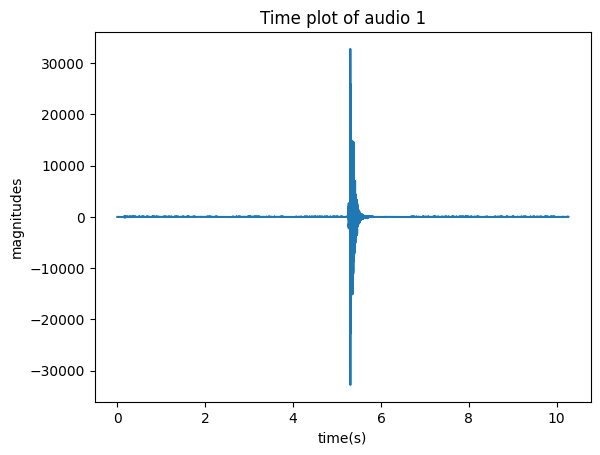

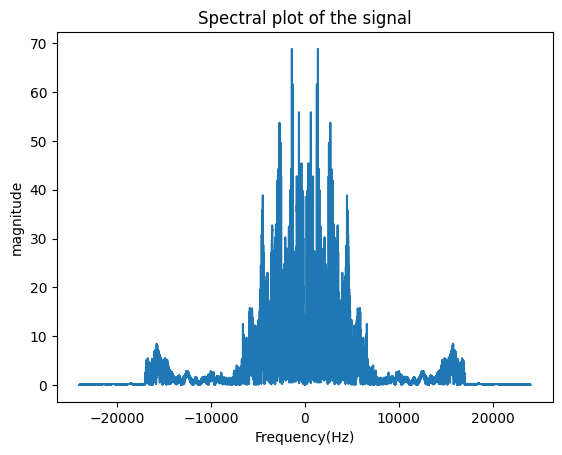

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


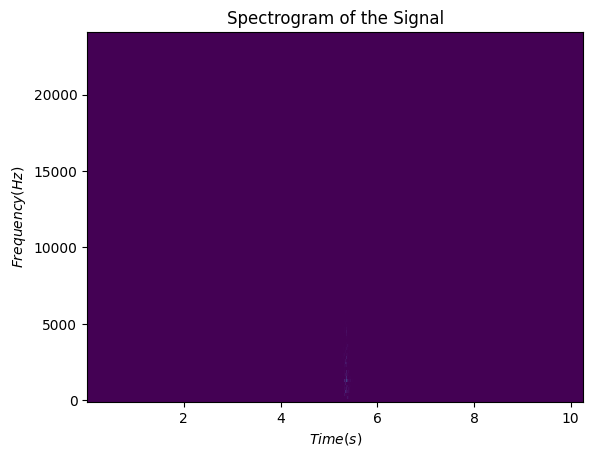

In [72]:
_5s_audio,rate=read_wav("hit_5s_audio.wav",True)
t=time_axis(_5s_audio.shape[0],1/rate)
time_plot(t,_5s_audio,title="Time plot of audio 1")
f=freq_axis(_5s_audio.shape[0],1/rate)
spectral_plot(f,_5s_audio,1/rate);
spectrogral_plot(_5s_audio,rate)

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


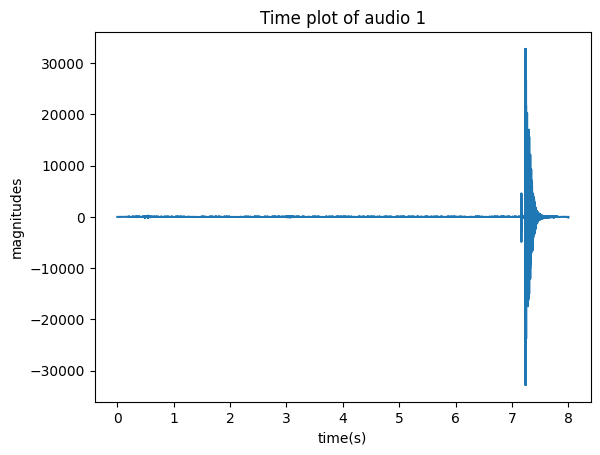

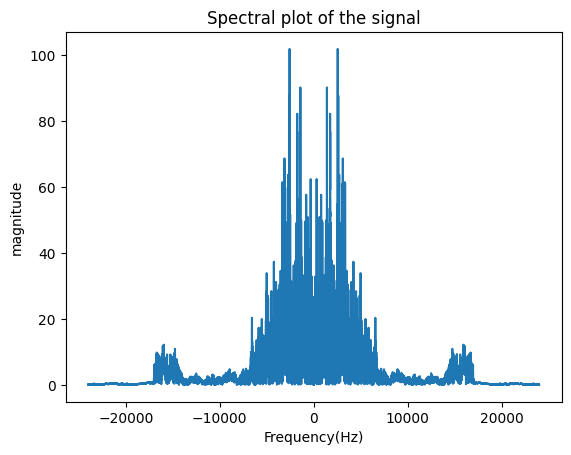

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


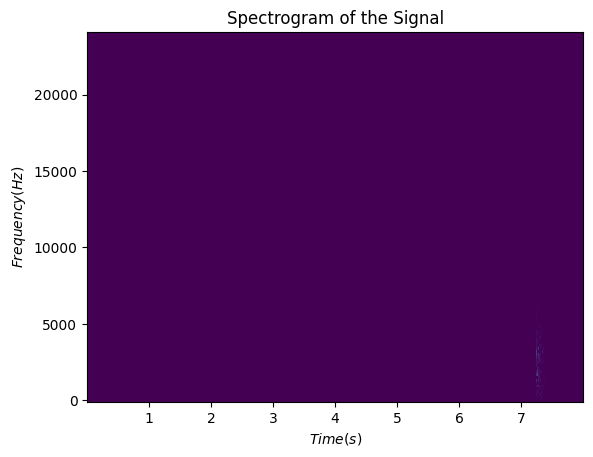

In [73]:
_7s_audio,rate=read_wav("hit_7s_audio.wav",True)
t=time_axis(_7s_audio.shape[0],1/rate)
time_plot(t,_7s_audio,title="Time plot of audio 1")
f=freq_axis(_7s_audio.shape[0],1/rate)
spectral_plot(f,_7s_audio,1/rate);
spectrogral_plot(_7s_audio,rate)

In [74]:
cc,d=gcc_phat(_5s_audio,_7s_audio,rate)
print(f"Estimated Delay {d}")

Estimated Delay 7.193
